Import libraries

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

Data pre-processing

In [19]:
train_data=pd.read_csv('drive/MyDrive/Colab Notebooks/newmltrain.csv')

In [20]:
train_data.shape

(8000, 1446)

In [21]:
train_data.dtypes.value_counts()

float64    1039
int64       406
object        1
dtype: int64

In [22]:
# Below code gives percentage of null in every column
null_percentage = train_data.isnull().sum()/train_data.shape[0]*100

# Below code gives list of columns having more than 60% null
col_to_drop = null_percentage[null_percentage>60].keys()

train_data = train_data.drop(col_to_drop, axis=1)

In [23]:
train_data.shape

(8000, 1446)

In [24]:
train_data.isna().sum().sort_values(ascending=False).head(10)

name         0
minssO       0
minsOH       0
minssssNp    0
minaasN      0
minddsN      0
minsssN      0
minaaN       0
mindsN       0
minsssNHp    0
dtype: int64

In [25]:
# get the columns with null values
null_cols = train_data.columns[train_data.isnull().any()]

# get the count of each data type for columns with null values
dtype_counts = train_data[null_cols].dtypes.value_counts()
dtype_counts

Series([], dtype: int64)

In [26]:
# get the mean of the columns with float data type
mean_values = train_data.select_dtypes(include=['float']).mean()

# replace missing values with mean for float columns
train_data[train_data.select_dtypes(include=['float']).columns] = train_data.select_dtypes(include=['float']).fillna(mean_values)

In [27]:
train_data=train_data.drop('name',axis=1)

X as the feature matrix, including all descriptors, and y as the response variable

In [28]:
X=train_data.drop('cls',axis=1)
y=train_data['cls']

Feature selection

In [29]:
from sklearn.feature_selection import VarianceThreshold

# Define the threshold value
threshold_value = 0.70  # Adjust as needed

# Initialize the VarianceThreshold selector
selector = VarianceThreshold(threshold=threshold_value)

# Apply the selector to the original DataFrame
X_selected = selector.fit_transform(X)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = X.columns[selected_indices]

# Create the final DataFrame with selected features
X = X[selected_features]

In [31]:
print(X.shape)


(8000, 510)


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
test_data=pd.read_csv('drive/MyDrive/Colab Notebooks/newmltest.csv')

In [34]:
test_data.shape

(2000, 1446)

In [35]:
X_test=test_data.drop('cls',axis=1)
y_test=test_data['cls']

In [36]:
common_columns = X_test.columns.intersection(selected_features)

In [37]:
X_test = X_test[common_columns]

In [38]:
print(X_test.shape)

(2000, 510)


Cross validation and model generation and ROC curve

Random Forest Metrics of Training Set:
AUC: 0.8344
MCC: 0.5165
Sensitivity: 0.7110
Specificity: 0.8033
Accuracy: 0.7571
Random Forest Metrics of Test Set:
Test Accuracy: 0.7675
AUC: 0.8468
MCC: 0.5364
Sensitivity: 0.7310
Specificity: 0.8040
------------------------------
[LightGBM] [Info] Number of positive: 4000, number of negative: 4000
[LightGBM] [Info] Total Bins 111236
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3600, number of negative: 3600
[LightGBM] [Info] Total Bins 110910
[LightGBM] [Info] Number of data points in the

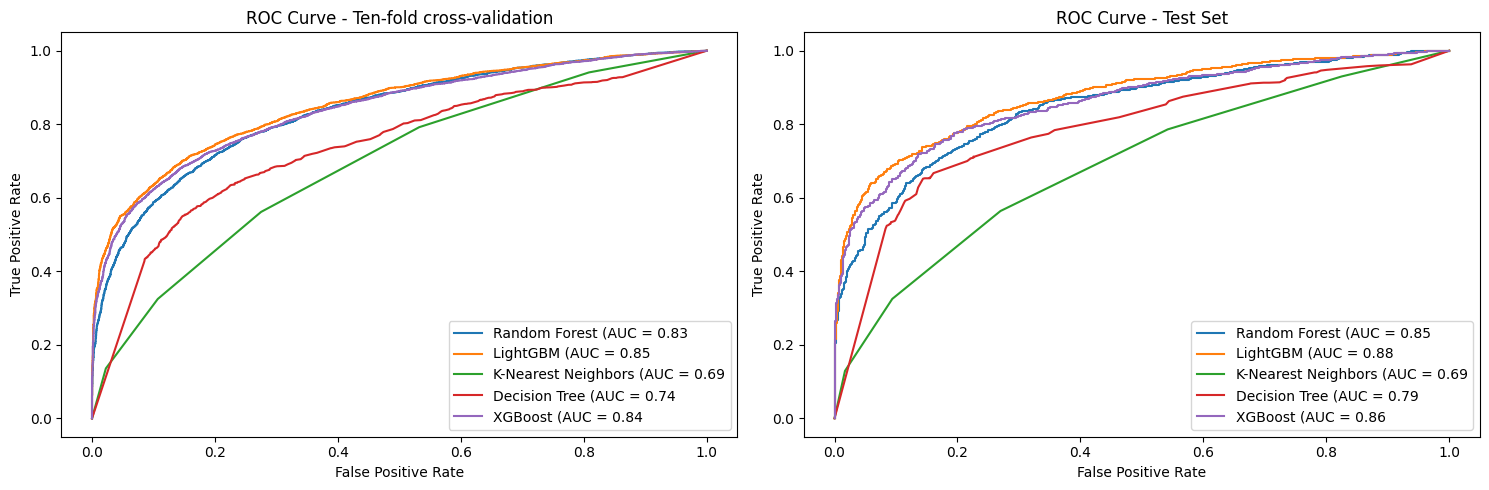

In [39]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=300,random_state=42,max_depth=10),
    'LightGBM': lgb.LGBMClassifier(force_col_wise=True, n_estimators=100, max_depth=10, num_leaves=50, learning_rate=0.2),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42),
    'XGBoost': xgb.XGBClassifier(learning_rate=0.1, max_depth=3, reg_lambda=0.5, n_estimators=100)
}

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Initialize the result dictionaries
train_results = {}
test_results = {}

# Loop through each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X, y)

    # Perform cross-validation and get predicted probabilities for training set
    y_probas_train = cross_val_predict(model, X, y, cv=10, method="predict_proba")[:, 1]

    # Calculate AUC for training set
    fpr_train, tpr_train, _ = roc_curve(y, y_probas_train)
    auc_train = roc_auc_score(y, y_probas_train)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y, (y_probas_train > 0.5).astype(int))

    # Calculate Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y, (y_probas_train > 0.5).astype(int)).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Calculate Accuracy
    accuracy_train = accuracy_score(y, (y_probas_train > 0.5).astype(int))

    train_results[model_name] = {
        'AUC': auc_train,
        'MCC': mcc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy_train
    }

    # Plot ROC curve for training set
    axs[0].plot(fpr_train, tpr_train, label=f'{model_name} (AUC = {auc_train:.2f}')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve - Ten-fold cross-validation')
    axs[0].legend()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy for the test set
    accuracy_test = accuracy_score(y_test, y_pred)
    test_results[model_name] = {'Test Accuracy': accuracy_test}

    # Predict on the test set
    y_probas_test = model.predict_proba(X_test)[:, 1]

    # Calculate AUC for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_probas_test)
    auc_test = roc_auc_score(y_test, y_probas_test)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, (y_probas_test > 0.5).astype(int))

    # Calculate Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, (y_probas_test > 0.5).astype(int)).ravel()
    sensitivity = tp / (tp + fn)


    # Plot ROC curve for test set
    axs[1].plot(fpr_test, tpr_test, label=f'{model_name} (AUC = {auc_test:.2f}')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve - Test Set')
    axs[1].legend()

    test_results[model_name]['AUC'] = auc_test
    test_results[model_name]['MCC'] = mcc
    test_results[model_name]['Sensitivity'] = sensitivity
    test_results[model_name]['Specificity'] = tn / (tn + fp)

    # Print results
    print(f'{model_name} Metrics of Training Set:')
    for metric, value in train_results[model_name].items():
        print(f'{metric}: {value:.4f}')

    print(f'{model_name} Metrics of Test Set:')
    for metric, value in test_results[model_name].items():
        print(f'{metric}: {value:.4f}')

    print('-' * 30)

plt.tight_layout()
plt.show()